### Импорт библиотек

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# Импорт библиотек для кластеризации
# Документация: https://scikit-learn.org/stable/modules/clustering.html
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram

In [3]:
# Импорт библиотек для визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Библиотека для построения Self-Organizing Maps: sklearn-som
# Документация библиотеки: https://sklearn-som.readthedocs.io/en/latest/index.html

# ! python3.7 -m pip install sklearn-som
from sklearn_som.som import SOM

## Загрузка данных

In [5]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'baseball.sas7bdat'

In [6]:
# Загружаем данные из SAS файла
df = pd.read_sas(file_path, encoding='latin-1')
# Пример данных
df.head()

,Name,Team,nAtBat,nHits,nHome,nRuns,nRBI,nBB,YrMajor,CrAtBat,...,CrBB,League,Division,Position,nOuts,nAssts,nError,Salary,Div,logSalary
0,"Allanson, Andy",Cleveland,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,...,14.0,American,East,C,446.0,33.0,20.0,NaN,AE,NaN
1,"Ashby, Alan",Houston,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,...,375.0,National,West,C,632.0,43.0,10.0,475.0,NW,6.163315
2,"Davis, Alan",Seattle,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,...,263.0,American,West,1B,880.0,82.0,14.0,480.0,AW,6.173786
3,"Dawson, Andre",Montreal,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,...,354.0,National,East,RF,200.0,11.0,3.0,500.0,NE,6.214608
4,"Galarraga, Andres",Montreal,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,...,33.0,National,East,1B,805.0,40.0,4.0,91.5,NE,4.516339


## Формирование признакового пространства

In [7]:
# Сформируем признаковое пространство:
# 1. YrMajor - число лет в лиге
# 2. Признаки с префиксом "n" - результаты 1986 года 
# 3. Признаки с префиксом "сr"  - результаты за всю карьеру

results_1986 = [c for c in df.columns if c[0] == "n"]
results_all = [c for c in df.columns if c[:2] == "Cr"]
sign_features = ['YrMajor'] + results_1986 + results_all

In [8]:
# Стандартизация признаков (вставьте свой код)
scaler = StandardScaler()
X = df.loc[:, sign_features]
X = pd.DataFrame(scaler.fit_transform(X), columns=sign_features)

## Часть 1: Иерархическая кластеризация и K-means

In [9]:
# Обучим модель Иерархической кластеризации
clustering = AgglomerativeClustering(compute_distances = True, distance_threshold = 0.0, n_clusters = None).fit(X)

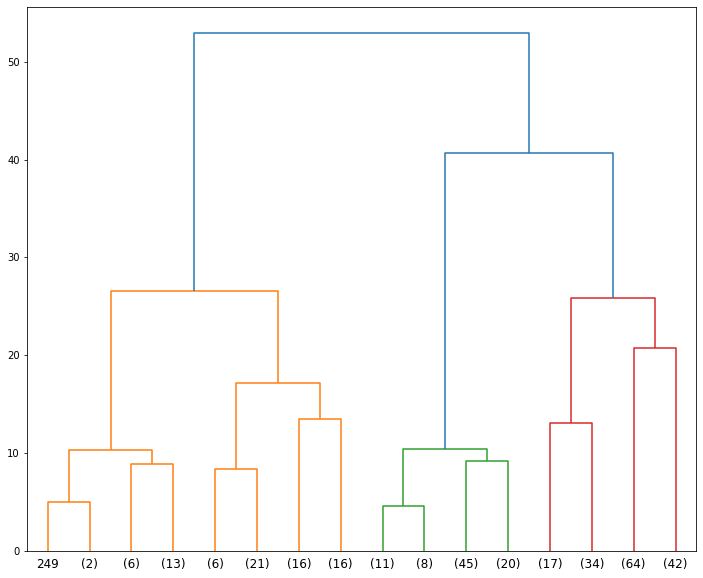

In [10]:
# Визуализация дендрограммы
def plot_dendrogram(model, **kwargs):
    # Создаем матрицу связности

    # Рассчитываем количество наблюдений в каждой вершине
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Лист
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    dendrogram(linkage_matrix, **kwargs, show_leaf_counts = True)

plot_dendrogram(clustering, truncate_mode="level", p=3)

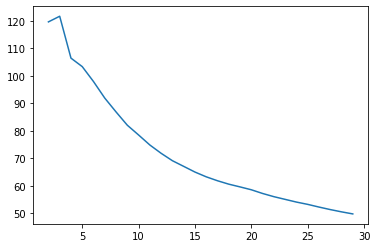

In [11]:
# Выберем число кластеров на основе псевдо критерия Фишера

def sum_dist_to_center(X):
    center = np.mean(X, axis = 0)
    return ((X - center)**2).values.sum()

def choose_num_clusters(X, max_clust = 30):
    N = X.shape[0]
    Q = sum_dist_to_center(X)
    pseudo_f = np.array([])
    for G in range(2, max_clust):
        clustering = AgglomerativeClustering(compute_distances = True, n_clusters = G).fit(X)
        W = 0
        for l in range(G):
            elems = X[clustering.labels_ == l]
            W += sum_dist_to_center(elems)
        fisher_stat = ((Q - W)/(G - 1))/(W/(N - G))
        pseudo_f = np.append(pseudo_f, fisher_stat)
    plt.plot(range(2, max_clust), pseudo_f)
    return np.argmax(pseudo_f)+2, pseudo_f

k, pseudo_f = choose_num_clusters(X)
clustering = KMeans(n_clusters=k, random_state=0).fit(X)
label = clustering.labels_

### Ответить на следующие вопросы:

#### 1.   Сколько кластеров было выбрано на основе псевдо критерия Фишера?
#### 2.   Используя информацию из графика, ответьте на вопросы:
> 1.   Каково значение критерия для выбранного числа кластеров?
> 2.   А для числа кластеров на один больше и на один меньше?

#### Q1

In [12]:
k

3

#### Q2.1

In [13]:
pseudo_f[k - 2]

121.61624755184556

#### Q2.2

In [14]:
pseudo_f[k - 3], pseudo_f[k - 1]

(119.5692901945296, 106.4084884247154)

## Часть 2: SOM

In [15]:
# Обучаем Self-Organizing Map с размером сетки 3 на 1
baseball_som = SOM(m=3, n=1, dim = X.shape[1])
baseball_som.fit(X.to_numpy())

labels = baseball_som.predict(X.to_numpy())

<AxesSubplot:ylabel='CrBB'>

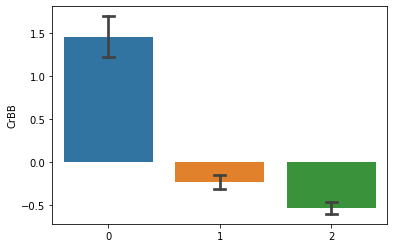

In [16]:
## Дополнительно #
## Значения признаков по кластерам удобно визуализировать с помощью barplot
## Нужное раскомментировать

## 1. В терминах matplotlib 
# plt.bar(labels, X["CrBB"])
# plt.ylabel("CrBB")
# plt.xlabel("cluster")

## 2. В терминах seaborn (+ доверительные интервалы)
sns.barplot(x = labels, y = X["CrBB"], capsize = 0.1)

## Часть 3: Анализ кластеров

## Построить модели:
> Для части 1: выбор количества кластеров на основе иерархической кластеризации с последующим обучение k-means

> Для части 2: обучение SOM с размером сетки 2 на 2 

## Ответить на следующие вопросы для каждой построенной модели
> Вариант I: Какой кластер содержит самых опытных игроков (переменная YrMajor)? 
> Вариант II: Какой кластер содержит самых успешных по хитам в 1986 году игроков (переменная nHits)?
> 1.	Сколько человек попало в этот кластер? 
> 2.    Как зовут самого типичного игрока в кластере вашего варианта (у него должно быть минимальное расстояние до центра вашего кластера)?

#### Q4.0

In [17]:
seed = 42
kmeans_l = KMeans(n_clusters=k, random_state=seed).fit_predict(X.to_numpy())
som_l = SOM(m=2, n=2, dim=X.shape[1], random_state=seed).fit_predict(X.to_numpy())

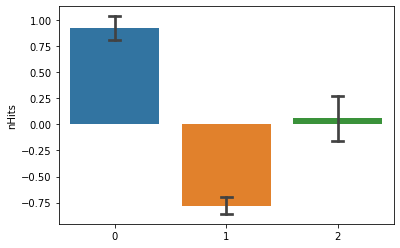

In [18]:
sns.barplot(x = kmeans_l, y = X["nHits"], capsize = 0.1);

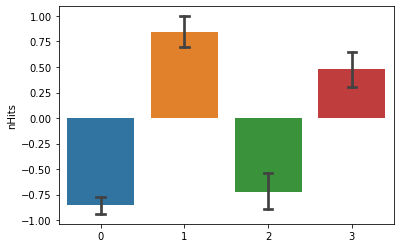

In [19]:
sns.barplot(x = som_l, y = X["nHits"], capsize = 0.1);

Т.к преобразование признаков было линейное, то достаточно посмотреть средние значения nHeats по кластерам.

Для модели kmeans 1-й кластер(из 3) содержит самых успешных по хитам в 1986 году игроков.

Для модели som 2-й кластер(из 4) содержит самых успешных по хитам в 1986 году игроков.

#### Q4.1

In [20]:
kmeans_x = X[kmeans_l == 0]
kmeans_names = df["Name"][kmeans_l == 0]
len(kmeans_x)

118

In [21]:
som_x = X[som_l == 1]
som_names = df["Name"][som_l == 0]
len(som_x)

96

#### Q4.2

In [22]:
def closest_to_center(X):
    center = X.mean(axis=0)
    z = np.argmin(((X - center) ** 2).sum(axis=1))
    return z


print(kmeans_names.iloc[closest_to_center(kmeans_x.to_numpy())])

Davis, Mike


In [23]:
print(som_names.iloc[closest_to_center(som_x.to_numpy())])


Howell, Jack
